---
title: Calibrate a physical model
authors:
  - name: Jianwen Du
    affiliations:
      - id: UoA
        institution: University of Arizona
        department: Hydrology and Atmospheric Sciences
license: Apache 2.0
date: 2025-08-07
---

## 🤔 Why Calibrate? 

Calibration of a physical model is the process of tuning its parameters to ensure its outputs accurately match real-world measurements. It's about bridging the gap between theoretical calculations and physical reality.

<div style="background-color:#E3F2FD; border-left: 5px solid #2196F3; padding: 15px; font-family:sans-serif;">
<b>Key Goal:</b> The primary goal is to improve predictive accuracy, transforming a model from a theoretical construct into a reliable tool for analysis and design.
</div>

## 📝 What Do You Need? 

To calibrate a model, you need four key components:

<div style="display: flex; flex-wrap: wrap; gap: 10px; font-family: sans-serif;">
  <div style="flex: 1; min-width: 200px; border: 1px solid #ccc; border-radius: 5px; padding: 10px; background: #fafafa;"><b>1. A Physical Model</b><br>A set of mathematical equations or simulation software.</div>
  <div style="flex: 1; min-width: 200px; border: 1px solid #ccc; border-radius: 5px; padding: 10px; background: #fafafa;"><b>2. Tunable Parameters</b><br>The specific "knobs" in your model that you can adjust.</div>
  <div style="flex: 1; min-width: 200px; border: 1px solid #ccc; border-radius: 5px; padding: 10px; background: #fafafa;"><b>3. Experimental Data</b><br>High-quality measurements from the real-world system.</div>
  <div style="flex: 1; min-width: 200px; border: 1px solid #ccc; border-radius: 5px; padding: 10px; background: #fafafa;"><b>4. An Objective Function</b><br>A metric that quantifies the error (e.g., RMSE).</div>
</div>

## ⚙️ How to Calibrate? 

There are two main approaches to calibration: by hand (trial and error) or by using a smart computer search (optimization algorithms). Optimization is highly recommended for its efficiency and accuracy.

<details>
<summary><b>Click to see details on different optimization methods</b></summary>
<div style="background-color:#E8F5E9; border-left: 5px solid #4CAF50; margin-top:10px; padding: 15px; font-family:sans-serif;">

- **Gradient-Based Methods:** Use the error gradient for efficient searching (e.g., Levenberg-Marquardt).
- **Gradient-Free Methods:** Do not require gradients, essential for "black-box" simulations (e.g., Nelder-Mead).
- **Bayesian Calibration:** Treats parameters as probability distributions to quantify uncertainty.
- **Cross-Calibration:** Calibrates one model against a trusted reference model to ensure consistency.
</div>
</details>

## ✅ How Do You Know It's Calibrated? 

A successful calibration can be verified by analyzing the errors and by validating the model against new data. A common way to visualize the result is by plotting the model's output against the experimental data.

### Interactive Example: Adjusting Model Parameters

To make this concept interactive, you can run the code cell below. It will create the same plot but with sliders that let you manually adjust the model's parameters (`slope` and `intercept`). Try to move the sliders to make the red line fit the blue dots. This gives you a hands-on feel for the "By Hand" calibration process.

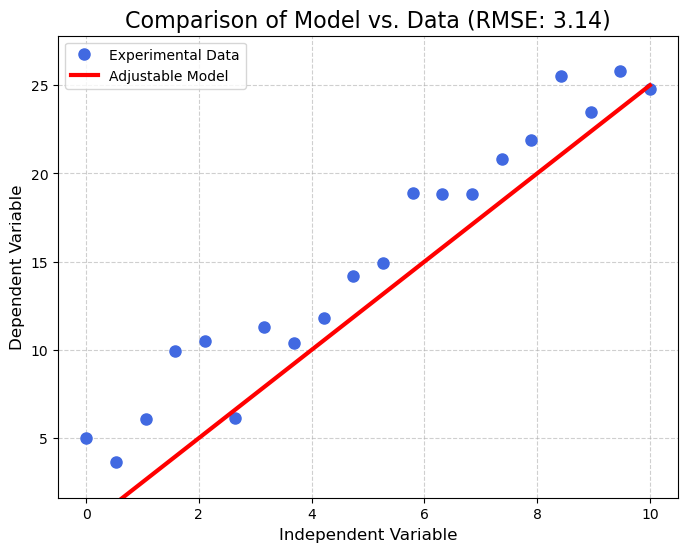

interactive(children=(FloatSlider(value=2.5, description='slope', max=5.0), FloatSlider(value=0.0, description…

In [1]:
# First, let's install ipywidgets for the interactive sliders
!pip install -q ipywidgets

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

# 1. Create the sample "Experimental Data"
np.random.seed(0)
x_data = np.linspace(0, 10, 20)
true_slope = 2.5
true_intercept = 1.5
y_data = true_slope * x_data + true_intercept + np.random.normal(0, 2, size=x_data.shape)

# 2. Define a function to plot the data and our adjustable model
def plot_model(x, y, slope, intercept):
    """Plots the experimental data against the model line defined by slope and intercept."""
    y_model = slope * x + intercept
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o', label='Experimental Data', markersize=8, color='royalblue')
    plt.plot(x, y_model, '-', label='Adjustable Model', linewidth=3, color='red')
    
    # Calculate and display the RMSE as our objective function score
    rmse = np.sqrt(np.mean((y - y_model)**2))
    plt.title(f'Comparison of Model vs. Data (RMSE: {rmse:.2f})', fontsize=16)
    
    plt.xlabel('Independent Variable', fontsize=12)
    plt.ylabel('Dependent Variable', fontsize=12)
    plt.ylim(min(y_data)-2, max(y_data)+2)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# 3. Create the interactive plot!
# The 'interact' function automatically creates sliders for the numerical arguments.
interact(plot_model, x=fixed(x_data), y=fixed(y_data), slope=(0.0, 5.0, 0.1), intercept=(-5.0, 5.0, 0.1));

# Example: Landsat calibration using MODIS SST
Create matchups between Landsat and MODIS SST data near Cosgrove, West Antarctica
to produce a calibration for Landsat SSTs

In [2]:
import earthaccess
%pip install seaborn
%pip install pykrige
%pip install xarray==2024.05.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries and modules
%config InlineBackend.figure_format = 'svg'
%matplotlib widget

%load_ext autoreload
%autoreload 2

import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
from matplotlib.patches import Polygon as Pgon
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
from sklearn.neighbors import BallTree
import pytz
import pygmt
import gc
import copy
import random
import statsmodels.formula.api as sm
import scipy.stats as stats
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point, Polygon
from pathlib import Path
import math
from scipy.odr import Model, RealData, ODR
from tqdm.notebook import trange, tqdm
import seaborn as sns

import earthaccess

# For LST file masking
import pystac_client
import intake
from rasterio.session import AWSSession
import boto3

import SSTutils as stu

import warnings
warnings.filterwarnings('ignore')

In [4]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

## Build Landsat - MODIS SST matchups

In [5]:
# Set paths and important variables and Calibration region bounding box

basepath = Path('/home/jovyan/landsatproduct-cookbook')
spacing = [990,-990] # 990m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
param = 'sea_surface_temperature'
size_threshold = 30

location = 0             # 0 and 1 are the Cosgrove and Dotson Polynya calibration areas, respectively
surf_temp = 'SST'        # 'SST' and 'LST' are for the Landsat SST and LST algorithms respectively

# Set location bounds
if location==1:
    pathdir = 'DotsonPolynya'
    latboundsC = [ -73.9 , -73.5 ] # Dotson polynya
    lonboundsC = [ -113 , -111.5 ]
    dfloc = 'Dotson'
elif location==0:
    pathdir = 'Cosgrove'
    latboundsC = [ -73.5 , -73.42 ] # near Cosgrove
    lonboundsC = [ -103.0 , -102.0 ]
    dfloc = 'Cosgrove'
elif location==2:
    pathdir = 'Burke'
    latboundsC = [ -73.81 , -73.42 ] # south of Burke
    lonboundsC = [ -104.2 , -103.8 ]
    dfloc = 'Burke'
if location==3:
    pathdir = 'DotsonIntercomp'
    latboundsC = [ -74.2 , -74.11 ] # Dotson plume for intercomparison
    lonboundsC = [ -113.5 , -113.17 ]
    dfloc = 'DotsonIntercomp'

# Coefficients for calibration
# SST
sstcalib_m = 0.76 
sstcalib_b = 0.55 

# LST
lstcalib_m = 0.80
lstcalib_b = 1.00

modmin = -1.9
LSTmin = np.around(modmin/lstcalib_m - lstcalib_b,2) 
SSTmin = np.around(modmin/sstcalib_m - sstcalib_b,2) # should be about -2.0

# Uncertainties used in ODR propagation of error
modis_uncertainty = 0.44  # long wave sst ocean color atbd
sst_uncertainty = 0.3 # USGS Landsat stray light notice
lst_uncertainty = 1.0 # gerace 2020
pix_uncertainty = np.sqrt((1000*1000)/(100*100)) # MODIS 1km x 1km and Landsat 100m x 100m


# For calibrated SST runs
if surf_temp=='SST':
    if location==3:
        sstpath = basepath / f'Data/SST/Validation/{pathdir}/'
    else:
        sstpath = basepath / f'Data/SST/MODcalib/{pathdir}/'
    tif = 'tif'
    thresh = SSTmin
    calib_m = sstcalib_m
    calib_b = sstcalib_b
    
# If running for LST comparisons
elif surf_temp=='LST':
    if location==3:
        sstpath = basepath / f'Data/SST/LST/Calibration/DotsonPolynya/'
    else:
        sstpath = basepath / f'Data/SST/LST/Calibration/{pathdir}/'
    tif = 'TIF'
    thresh = LSTmin
    calib_m = lstcalib_m
    calib_b = lstcalib_b

In [6]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="interactive")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [7]:
# Convert bounding box to south polar stereo for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

bbox,checkbox = stu.lsat_reproj(source_crs,target_crs,(lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]))

# Create polygon for later cropping
polygon = Polygon([(bbox[0][0],bbox[0][1]),(bbox[3][0],bbox[3][1]),(bbox[2][0],bbox[2][1]),(bbox[1][0],bbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

In [8]:
# Get Landsat file paths in directory
lsatfiles = os.listdir(sstpath)
lsatfiles = [x for x in lsatfiles if x[-3:] == tif]
lsatfiles.sort()
print (len(lsatfiles))
os.chdir(sstpath)

23


In [9]:
SSTfails = [
 'LC08_L1GT_006112_20221024_20221107_02_T2_152257_Cel.tif',
 'LC08_L1GT_006112_20221024_20221107_02_T2_152257_Cel.tif',
]
LSTfails = [
 'LC08_L1GT_007112_20211215_20211223_02_T2_SW_LST.TIF',
 'LC08_L1GT_007112_20220201_20220211_02_T2_SW_LST.TIF',
 'LC08_L1GT_007112_20221202_20221212_02_T2_SW_LST.TIF',
 'LC08_L1GT_007112_20230204_20230209_02_T2_SW_LST.TIF',
 'LC08_L1GT_008113_20221022_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010112_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_012112_20221018_20221031_02_T2_SW_LST.TIF',
 'LC08_L1GT_008113_20221022_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010112_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20220105_20220114_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20220121_20220128_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20221105_20221115_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20230108_20230124_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20230313_20230321_02_T2_SW_LST.TIF',
 'LC08_L1GT_012112_20221018_20221031_02_T2_SW_LST.TIF'
]

## Search for desired Landsat scenes

In [10]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [11]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37851/status,
Dashboard: http://127.0.0.1:37851/status,Workers: 4
Total threads: 4,Total memory: 15.16 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39149,Workers: 0
Dashboard: http://127.0.0.1:37851/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36547,Total threads: 1
Dashboard: http://127.0.0.1:40157/status,Memory: 3.79 GiB
Nanny: tcp://127.0.0.1:43669,


In [12]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9

In [13]:
i=0 # We will use the first image as an example
ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
ls_scene

<xarray.DataArray 'band_data' (y: 8391, x: 8321)> Size: 559MB
dask.array<getitem, shape=(8391, 8321), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 67kB -1.904e+06 -1.904e+06 ... -1.654e+06
  * y            (y) float64 67kB -1.941e+05 -1.941e+05 ... -4.458e+05
    spatial_ref  int64 8B ...
Attributes:
    MODIS_WV:       MOD07_L2.A2021266.1420.061.2021267012756.hdf.nc4
    AREA_OR_POINT:  Area

In [14]:
%%time
# ~1 min 32 sec per image
# If number of MODIS images per satellite is much more than 25, its because there is a ULY,LRY issue
os.chdir('/home/jovyan/landsatproduct-cookbook/Data/SST/MODcalib/Cosgrove/')

lsat_mod = []
for i in tqdm(range(len(lsatfiles)), desc="Processing"):
    # Check for known repeatedly bad files that will kill the code
    if surf_temp == 'SST':    
        if lsatfiles[i] in SSTfails:
            continue
    elif surf_temp == 'LST':
        if lsatfiles[i] in LSTfails:
            continue
        
    # Concatenate all landsat files into xarray with a time dimension
    ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
    if surf_temp == 'SST':
        times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])
    elif surf_temp == 'LST':
        # Need to mask LST because not done previously
        mask = stu.get_lst_mask(lsatfiles[i])
        ls_scene = ls_scene * mask
        
        times = pd.to_datetime(lsatfiles[i][17:25]+'120000', format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-4])
        ls_scene = ls_scene - 273.15

    # Subset scene and check that it has the correct dimensions because y order changes sometimes
    ls_scene = stu.subset_img(ls_scene,polarx,polary) # subset so easier to work with
    ls_scene = stu.crop_xarray_dataarray_with_polygon(ls_scene, polygon) # crop data to exact bounding box

    lsID = lsatfiles[i]
    
    # Take mean temp, will skip the modis stage if no Landsat data in the calibration region
    try:
        lsat = np.nanmean(ls_scene)
    except Exception as e:
        lsat = np.nan

    if ~np.isfinite(lsat):
        continue

    # Find coincident MODIS SST scene
    mod_scene, mod_file,time_dif = stu.find_MODIS(lonboundsC,latboundsC,ls_scene)

    try:
        # Acquire and align MODIS data to Landsat
        MODsst_xr = stu.get_sst(ls_scene,mod_scene.sea_surface_temperature,spacing,param)
        # Remove SSTs that are unrealistically cool
        MODsst_xr = MODsst_xr.where(MODsst_xr >= -1.9, np.nan)
        # Crop Landsat image to meet the slightly smaller MODIS image
        ls_scene = stu.subset_img(ls_scene,[MODsst_xr.x.min(),MODsst_xr.x.max()],[MODsst_xr.y.min(),MODsst_xr.y.max()])
        # Only use MODIS data where cropped Landsat data is also available
        MODsst_xr_sub = MODsst_xr.where(ls_scene.notnull(),np.nan)
        # Take mean temp
        modis = np.nanmean(MODsst_xr_sub)
        MOD_num = MODsst_xr_sub.notnull().values.sum()
    except Exception as e:
        modis = np.nan
        MOD_num = 0

    # Take mean using Landsat data only where cropped MODIS data is also available (need to do both)
    try:
        ls_scene_sub = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
        lsat = np.nanmean(ls_scene_sub)
        ls_num = ls_scene_sub.notnull().values.sum()
    except Exception as e:
        lsat = np.nan
        ls_num = 0 # FIX: Initialize ls_num in case of exception

    # Append file names with SST means from the Cosgrove box
    lsat_mod.append([times,mod_file,modis,MOD_num,lsID,lsat,ls_num,time_dif])
    
    try:
        del ls_scene, mod_scene, MODsst_xr, MODsst_xr_sub
    except:
        pass

    gc.collect()

Processing:   0%|          | 0/23 [00:00<?, ?it/s]

29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:37:55


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

28 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:37:59


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

28 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:37:57


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:57:07


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:41


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:05


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
29 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:08


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:13


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:09


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

24 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
22 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:01


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:59


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:43:35


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

26 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:14


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:12


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

30 TOTAL MODIS granules
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

30 TOTAL MODIS granules
30 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:35


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

29 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:30


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:23


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:16


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5min 49s, sys: 2min 10s, total: 8min
Wall time: 20min 56s


In [15]:
# Put data into DataFrame and save    
headers = ['DateTime','MODIS_filename','MODIS_SST','MODIS_pix','L8_filename',f'L8_{surf_temp}','L8_pix','time_dif']
lsat_mod_df = pd.DataFrame(lsat_mod,columns=headers)
out_df = basepath / f'Data/MODISvLandsat_{surf_temp}_{dfloc}_20250500.csv'
lsat_mod_df.to_csv(out_df, index=False)

In [16]:
print (out_df)

/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_SST_Cosgrove_20250500.csv


## Calculate calibration bias and trend

In [17]:
# Read in paired MODIS/Landsat data created above
surf_temp = 'SST'

if surf_temp=='LST':
    thresh = -3.5 # -3.4 is ok too
    pix_thresh = 1300
elif surf_temp=='SST':
    thresh = -3.1
    pix_thresh = 1300
mod_sst_thresh = -1.9

# For Cosgrove region
if surf_temp=='LST':
    out_df_C = '/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_LST_Cosgrove.csv'
else:   
    out_df_C = '/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_SST_Cosgrove_lin_scale.csv' 
lsat_mod_df_C = pd.read_csv(out_df_C)
lsat_mod_df_C['Region'] = 'Cosgrove'

# For Dotson polynya region
if surf_temp=='LST':
    out_df_D = '/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_LST_Dotson.csv'
else:
    out_df_D = '/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_SST_Dotson_lin_scale.csv'  
lsat_mod_df_D = pd.read_csv(out_df_D)
lsat_mod_df_D['Region'] = 'Dotson'

# For Burke region
if surf_temp=='LST':
    out_df_B = '/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_LST_Burke.csv'
else:
    out_df_B = '/home/jovyan/landsatproduct-cookbook/Data/MODISvLandsat_SST_Burke_lin_scale.csv'
lsat_mod_df_B = pd.read_csv(out_df_B)
lsat_mod_df_B['Region'] = 'Burke'

# Concatenate data from all regions
lsat_mod_df_n = pd.concat([lsat_mod_df_B,lsat_mod_df_C,lsat_mod_df_D])
print(f'Original # matchups at Cosgrove: {lsat_mod_df_C.shape[0]}, at Dotson: {lsat_mod_df_D.shape[0]}, at Burke: {lsat_mod_df_B.shape[0]}')

Original # matchups at Cosgrove: 66, at Dotson: 120, at Burke: 100


In [18]:
# sum_n = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_n = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([2])]
# sum_c = lsat_mod_df_C[lsat_mod_df_C.DateTime.dt.month.isin([9,10,11,12,1,3])]
# sum_bc = lsat_mod_df_bc[lsat_mod_df_bc.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_bc = lsat_mod_df_bc[lsat_mod_df_bc.DateTime.dt.month.isin([2])]
# sum_bd = lsat_mod_df_bd[lsat_mod_df_bd.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_bd = lsat_mod_df_bd[lsat_mod_df_bd.DateTime.dt.month.isin([2])]
# sum_cd = lsat_mod_df_cd[lsat_mod_df_cd.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_cd = lsat_mod_df_cd[lsat_mod_df_cd.DateTime.dt.month.isin([2])]

In [19]:
# # ***check all the february images to see if we need to add a threshold of 2.0C or cut images or if the issue is clouds???
# # shld
# look = lsat_mod_df_n.sort_values('L8_filename')
# look.head(20)

In [20]:
# Orthoganal Regression 
if surf_temp=='LST':
    data0 = lsat_mod_df_n
    landsat_uncertainty = lst_uncertainty
else:
    data0 = lsat_mod_df_n
    landsat_uncertainty = sst_uncertainty

# Original data
x_original = np.array(data0[f'L8_{surf_temp}'])
y_original = np.array(data0['MODIS_SST'])

# Assume these are your uncertainty estimates per observation
sy = np.full_like(y_original, modis_uncertainty * pix_uncertainty)  # Adjusted for resolution mismatch
sx = np.full_like(x_original, landsat_uncertainty)

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original,sx=sx, sy=sy)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Compute RMSE
rmse = np.sqrt(((y_original - y_pred) ** 2).mean())

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))
print(f"RMSE: {np.around(rmse,2)}")

Beta: [1. 0.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
R^2: nan
RMSE: nan


In [21]:
if surf_temp=='LST':
    # Plot regression
    beta_mdn = [beta[0]-beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
    beta_mup = [beta[0]+beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
    beta_bdn = [beta[0]-beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
    beta_bup = [beta[0]+beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
    print(f'At 95% confidence interval: {np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}, n={y_pred.shape[0]}')
    xfill = np.array([-4.5,1.5])
    
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.tick_params(labelsize=14)
    
    # LST data and regression
    plt.scatter(x_original, y_original, s=12,color='mediumslateblue')
    plt.plot(x_original, y_pred, color='mediumslateblue', label='LST ODR')
    plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')
    
    # Comparison regressions
    xi = np.arange(-7.0,5.0,1.0)
    plt.plot(xi,xi * sstcalib_m + sstcalib_b,color='k',linewidth=2,label='SST ODR')
    plt.plot(xi,xi,color='lightcoral',linewidth=2, label='MODIS 1:1')
        
    plt.legend(loc='lower right',fontsize=14)
    plt.text(-2.7,-0.15,rf'$\mathbf{{y={np.around(beta[0],2)}x+{np.around(beta[1],2)}\quad r^2={np.around(R2,2)}}}$',color='mediumslateblue', fontweight='bold',fontsize=14)
    plt.xlim([-3.5,-1.2])
    plt.ylim([-3.05,0.8])
    # else: 
    #     plt.plot(x_original, y_pred, color='k', label='NLSST Orthogonal Distance Regression')
    #     plt.legend(loc='lower right',fontsize=12)
    #     plt.text(-2.6,-0.2,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
    #     plt.xlim([-3.2,-0.15])
    #     plt.ylim([-2.4,0.9]) 
    plt.xlabel('Landsat ST [°C]',fontsize=16)
    plt.ylabel('MODIS SST [°C]',fontsize=16)
    plt.tight_layout()

In [22]:
# Orthoganal Regression for SST only
dataframes = [
    ('Combined', lsat_mod_df_n),
    ('Burke', lsat_mod_df_B),
    ('Cosgrove', lsat_mod_df_C),
    ('Dotson', lsat_mod_df_D),
]

if surf_temp=='LST':
    landsat_uncertainty = lst_uncertainty
else:
    landsat_uncertainty = sst_uncertainty

# Dictionary to store the results from each DataFrame
odr_results = {}

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model object
linear = Model(linear_model)

# Loop over each DataFrame
for df_name, data0 in dataframes:
    print(f"\n=== Processing {df_name} ===")
    
    # Original data
    x_original = np.array(data0[f'L8_{surf_temp}'])
    y_original = np.array(data0['MODIS_SST'])

    # Assume these are your uncertainty estimates per observation
    sy = np.full_like(y_original, modis_uncertainty * pix_uncertainty)  # Adjusted for resolution mismatch
    sx = np.full_like(x_original, landsat_uncertainty)
    
    # Create a RealData object using your DataFrame
    data = RealData(x_original, y_original,sx=sx, sy=sy)
    
    # Set up ODR with the model and data, providing an initial guess
    odr = ODR(data, linear, beta0=[1., 0.])
    
    # Run the regression
    out = odr.run()
    
    # Retrieve best-fit parameters and their std. dev.
    beta = out.beta
    beta_err = out.sd_beta
    
    # Print the summary
    out.pprint()
    
    # Predicting values using the ODR model
    y_pred = linear_model(beta, x_original)
    
    # Get R2
    # Calculate Total Sum of Squares (SST)
    y_mean = np.mean(y_original)
    SST = np.sum((y_original - y_mean)**2)
    
    # Calculate Residual Sum of Squares (SSR)
    SSR = np.sum((y_original - y_pred)**2)
    
    # Calculate R^2
    R2 = 1 - (SSR / SST)

    # Compute RMSE
    rmse = np.sqrt(((y_original - y_pred) ** 2).mean())
    
    # Print R^2
    print(f"{df_name} R^2:", np.around(R2, 2))
    print(f"RMSE: {np.around(rmse,2)}")
    
    # Store results in a dictionary for later use (plotting, etc.)
    odr_results[df_name] = {
        'beta': beta,
        'beta_err': beta_err,
        'R2': R2,
        'x_original': x_original,
        'y_original': y_original,
        'y_pred': y_pred
    }


=== Processing Combined ===
Beta: [1. 0.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Combined R^2: nan
RMSE: nan

=== Processing Burke ===
Beta: [1. 0.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Burke R^2: nan
RMSE: nan

=== Processing Cosgrove ===
Beta: [1. 0.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Cosgrove R^2: nan
RMSE: nan

=== Processing Dotson ===
Beta: [1. 0.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected
Dotson R^2: nan
RMSE: nan


At 95% confidence interval: 1.0+/-0.0, 0.0+/-0.0, n=286


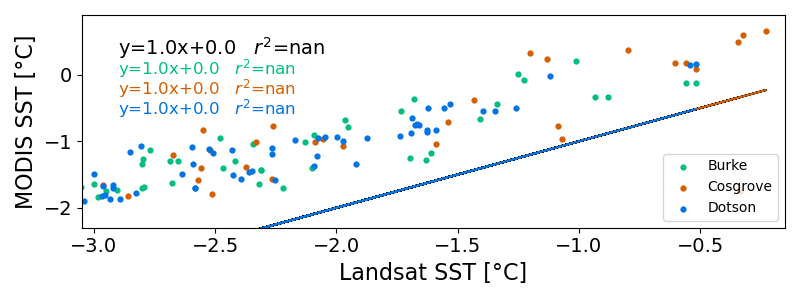

In [23]:
if surf_temp=='SST':
    # Plot with all points and by region (Burke=r, Cosgrove=b, Dotson=g) - show with lsat_mod_df_n calculations for the line
    beta_mdn = [odr_results['Combined']['beta'][0]-odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]-odr_results['Combined']['beta_err'][1]*1.96]
    beta_mup = [odr_results['Combined']['beta'][0]+odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]-odr_results['Combined']['beta_err'][1]*1.96]
    beta_bdn = [odr_results['Combined']['beta'][0]-odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]+odr_results['Combined']['beta_err'][1]*1.96]
    beta_bup = [odr_results['Combined']['beta'][0]+odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]+odr_results['Combined']['beta_err'][1]*1.96]
    a1 = np.around(odr_results['Combined']['beta'][0],2)
    a1e = np.around(odr_results['Combined']['beta_err'][0]*1.96,2)
    a2 = np.around(odr_results['Combined']['beta'][1],2)
    a2e = np.around(odr_results['Combined']['beta_err'][1]*1.96,2)
    nn = odr_results['Combined']['y_pred'].shape[0]
    ar = np.around(odr_results['Combined']['R2'],2)
    b1 = np.around(odr_results['Burke']['beta'][0],2)
    b2 = np.around(odr_results['Burke']['beta'][1],2)
    br = np.around(odr_results['Burke']['R2'],2)
    c1 = np.around(odr_results['Cosgrove']['beta'][0],2)
    c2 = np.around(odr_results['Cosgrove']['beta'][1],2)
    cr = np.around(odr_results['Cosgrove']['R2'],2)
    d1 = np.around(odr_results['Dotson']['beta'][0],2)
    d2 = np.around(odr_results['Dotson']['beta'][1],2)
    dr = np.around(odr_results['Dotson']['R2'],2)
    print(f'At 95% confidence interval: {a1}+/-{a1e}, {a2}+/-{a2e}, n={nn}')
    xfill = np.array([-4.3,0.9])
    
    
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.tick_params(labelsize=14)
    
    plt.scatter(np.array(lsat_mod_df_B[f'L8_{surf_temp}']), np.array(lsat_mod_df_B['MODIS_SST']), s=12,color='#00bf7d', label='Burke')
    plt.scatter(np.array(lsat_mod_df_C[f'L8_{surf_temp}']), np.array(lsat_mod_df_C['MODIS_SST']), s=12,color=sns.color_palette("colorblind")[3], label='Cosgrove')
    plt.scatter(np.array(lsat_mod_df_D[f'L8_{surf_temp}']), np.array(lsat_mod_df_D['MODIS_SST']), s=12,color='#0073e6', label='Dotson')
    
    plt.plot(odr_results['Combined']['x_original'], odr_results['Combined']['y_pred'], color='k')
    plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')
    plt.plot(odr_results['Burke']['x_original'], odr_results['Burke']['y_pred'], ls='-',linewidth=1,color='#00bf7d')
    plt.plot(odr_results['Cosgrove']['x_original'], odr_results['Cosgrove']['y_pred'], ls='-',linewidth=1,color=sns.color_palette("colorblind")[3])
    plt.plot(odr_results['Dotson']['x_original'], odr_results['Dotson']['y_pred'], ls='-',linewidth=1,color='#0073e6')
    
    if surf_temp=='LST':
        plt.text(-2.25,-0.2,f'y={a1}x+{a2}   $r^2$={ar}',color='#00bf7d',fontsize=14)
        plt.text(-2.25,-0.2,f'y={c1}x+{c2}   $r^2$={cr}',color=sns.color_palette("colorblind")[3],fontsize=12)
        plt.text(-2.25,-0.2,f'y={d1}x+{d2}   $r^2$={dr}',color='#0073e6',fontsize=12)
        plt.xlim([-2.5,-1.4])
        plt.ylim([-2.05,0.0])
    else: 
        plt.text(-2.9,0.3,f'y={a1}x+{a2}   $r^2$={ar}',color='k',fontsize=14)
        plt.text(-2.9,0.0,f'y={b1}x+{b2}   $r^2$={br}',color='#00bf7d',fontsize=12)
        plt.text(-2.9,-0.3,f'y={c1}x+{c2}   $r^2$={cr}',color=sns.color_palette("colorblind")[3],fontsize=12)
        plt.text(-2.9,-0.6,f'y={d1}x+{d2}   $r^2$={dr}',color='#0073e6',fontsize=12)
        plt.xlim([-3.05,-0.15])
        plt.ylim([-2.3,0.9])
    plt.xlabel('Landsat SST [°C]',fontsize=16)
    plt.ylabel('MODIS SST [°C]',fontsize=16)
    plt.legend(loc='lower right',fontsize=10)
    plt.tight_layout()

In [24]:
odr_results['Combined']['beta_err']

array([0., 0.])

In [25]:
if surf_temp=='SST':
    # Ordinary least squares regression between Landsat and MODIS SST matchups
    resultC = sm.ols(formula="MODIS_SST ~ L8_SST", data=data0).fit()
    print (resultC.summary())

                            OLS Regression Results                            
Dep. Variable:              MODIS_SST   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     90.86
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           7.85e-14
Time:                        21:28:36   Log-Likelihood:                -19.068
No. Observations:                  65   AIC:                             42.14
Df Residuals:                      63   BIC:                             46.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1929      0.113     -1.705      0.0